In [1]:
from IPython.display import Image
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt

import modules.calc as calc

### Our puzzle image

In [2]:
imageName='res/IMG_2024.jpg'

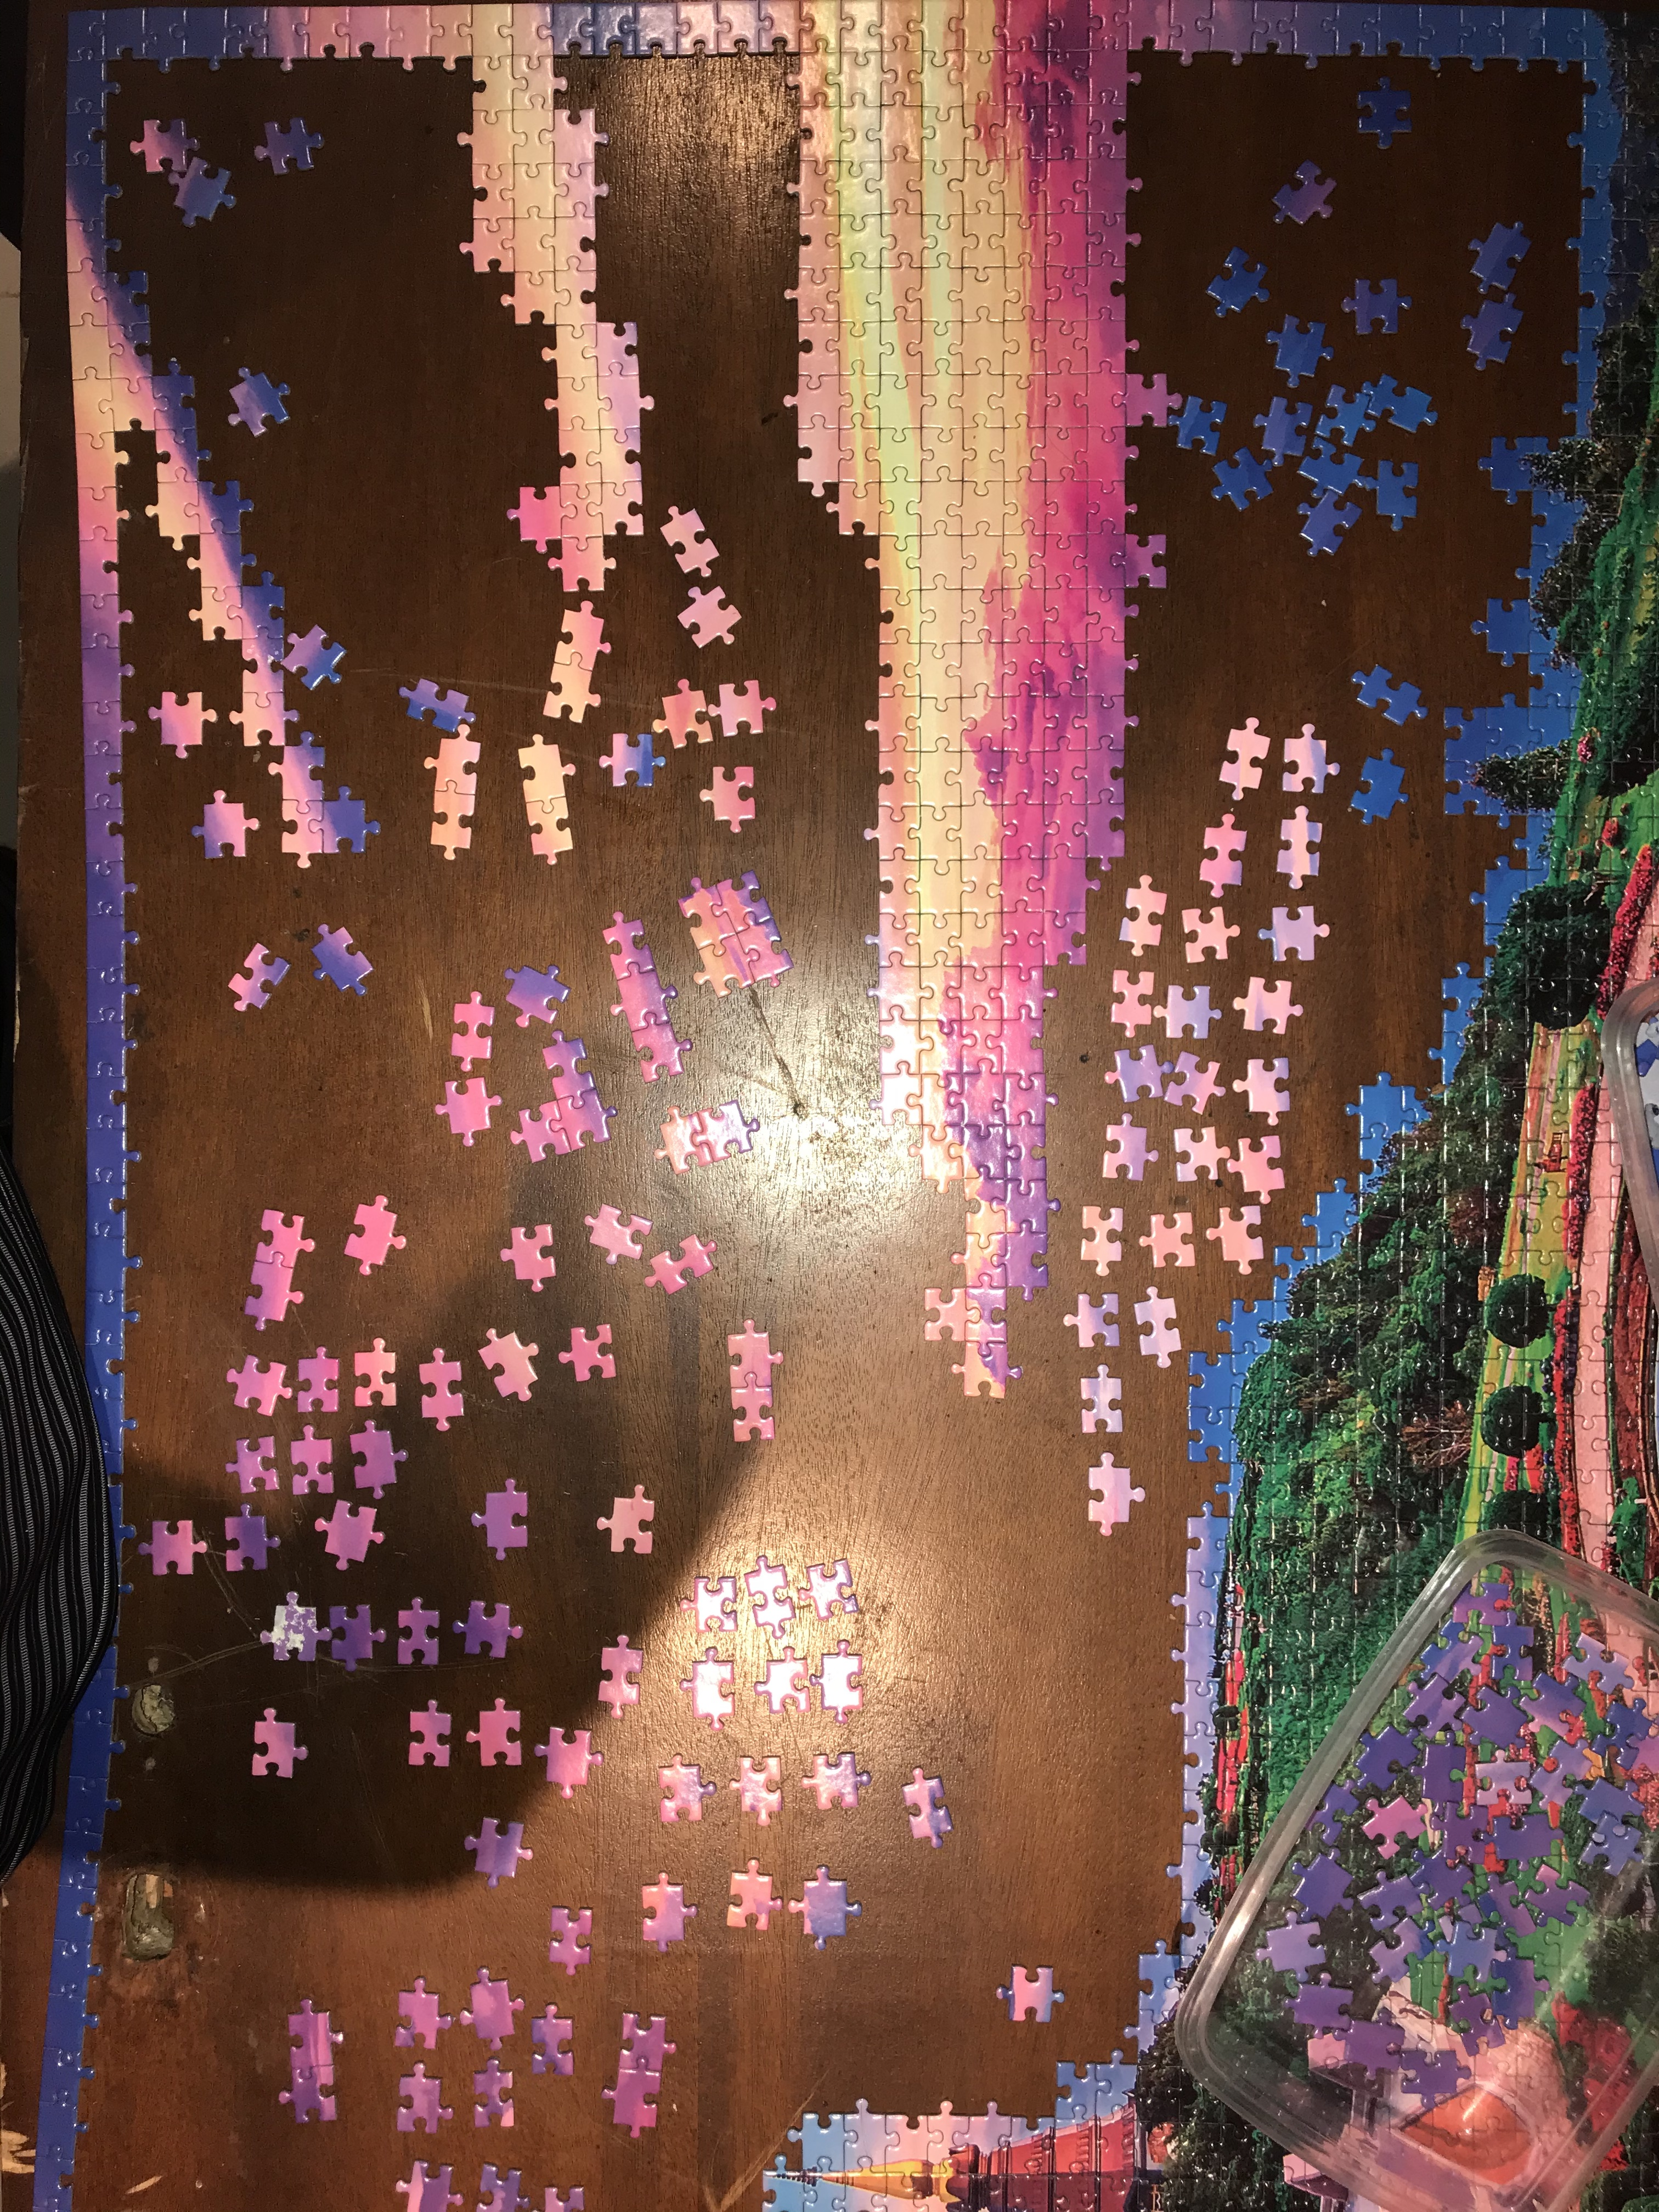

In [3]:
Image(filename=imageName)

### Generate a mask over piece locations

(700, 800, 3)


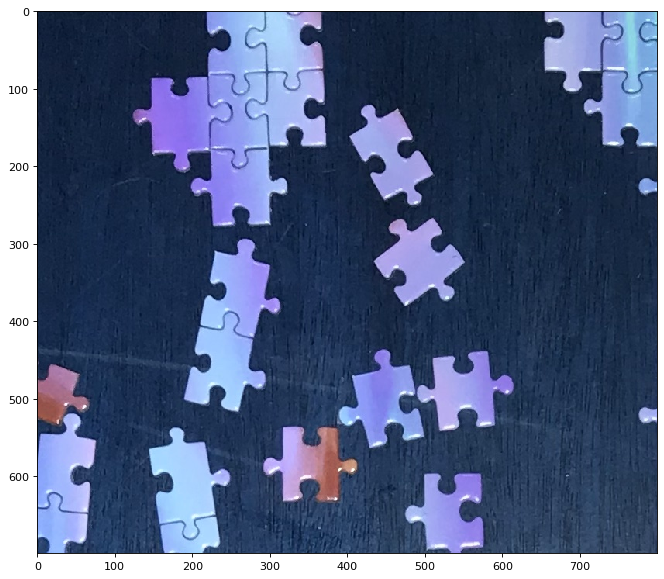

(700, 800)


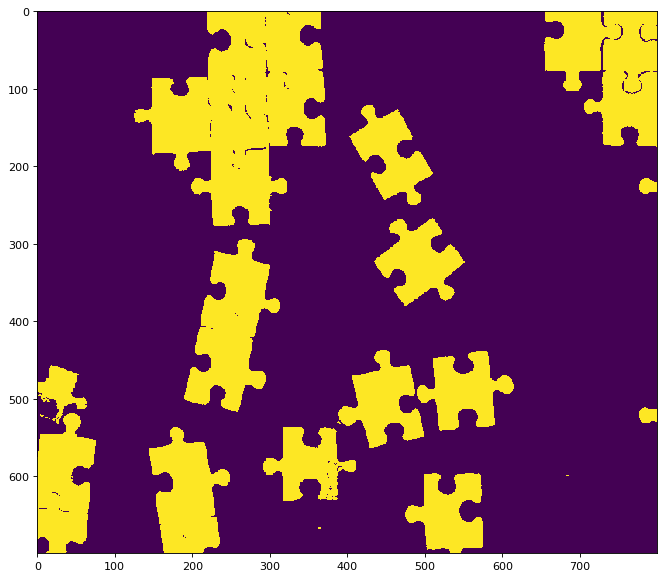

CONNECTED
23
(700, 800)
(23, 5)
(23, 2)
(700, 800)
PIECES
(22, 700, 800)


In [4]:
original_img = cv2.imread(imageName,cv2.IMREAD_COLOR)[800:1500,800:1600]#[2000:2170,2000:2150]
print(original_img.shape)
imghsv = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)

fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(original_img)
plt.show()

# edges = cv2.blur(imghsv,(1, 1))
edges = imghsv
# print(edges.shape)

# kernel = np.ones((2,2))
# edges = cv2.erode(edges, kernel, iterations=2)
# edges = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel, iterations=1)
# edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
# edges = cv2.dilate(edges,kernel,iterations=2)

edgesv = edges[:,:,2]

_,edges = cv2.threshold(edgesv,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(edges.shape)

fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(edges)
plt.show()

nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(edges, connectivity=8)
sizes = stats[:,4]
print("CONNECTED")
print(nb_components)
print(labels.shape)
print(stats.shape)
print(centroids.shape)
print(edges.shape)

nb_components = nb_components - 1
min_size = 1000
max_size = 10000

print("PIECES")
pieces = np.zeros((nb_components, edges.shape[0], edges.shape[1]), dtype=np.dtype('uint8'))
print(pieces.shape)

# mask = np.zeros(edges.shape, dtype=np.dtype('uint8'))
#info: 0:width 1:height
for i in range(0, nb_components):
    x = stats[i][0]
    y = stats[i][1]
    w = stats[i][2]
    h = stats[i][3]
    if sizes[i] >= min_size and sizes[i] <= max_size:
        pieces[i,0:h,0:w][labels[y:y+h, x:x+w]==i] = 254
#         fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
#         plt.imshow(pieces[i,0:h,0:w])
#         plt.show()


### For each piece, extract its location and core body so that we can compare its boundaries to other pieces

FIND PIECE BODY
.
.
.
.
.
.
.


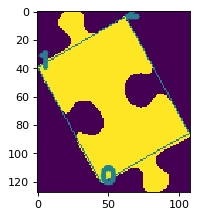

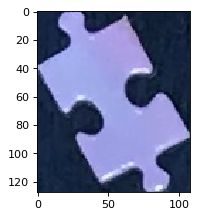

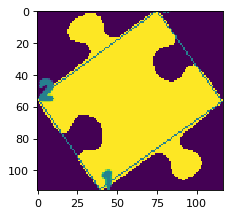

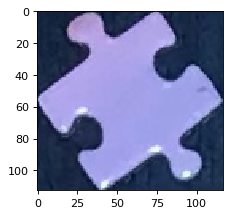

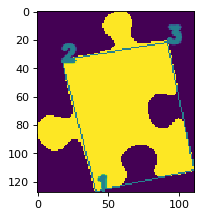

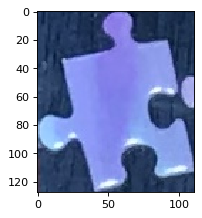

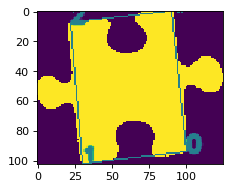

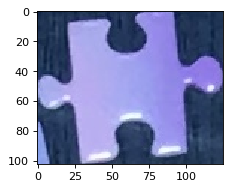

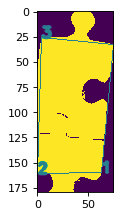

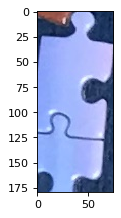

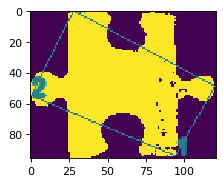

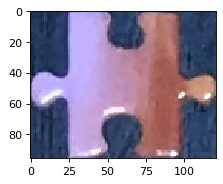

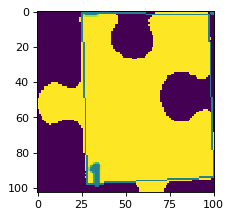

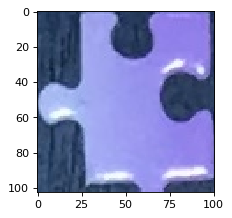

In [19]:
print("FIND PIECE BODY")

class Piece:
    original_left = None
    original_top = None
    width = None
    height = None
    mask = None
    body_points = None
    image = None
    debug_image = None

    def rotate(self, rotate_center, rotate_angle):
        s = self.image.shape
        print("====")
        print(s)
        w = s[0]
        h = s[1]
        w1 = int(math.sqrt(w*w + h*h))
        h1 = w1
        
        xt = int((w1-w)/2)
        yt = int((h1-h)/2)

        rotate_center = (int(w1/2), int(h1/2))
        print(rotate_center)
        
        imager = np.zeros((w1,h1,s[2]), np.uint8)
        imager[xt:xt+w,yt:yt+h] = self.image[0:w,0:h]
        imager = calc.rotate_image(imager, rotate_center, -rotate_angle)

#         fig=plt.figure(figsize=(4, 4), dpi= 80, facecolor='w', edgecolor='k')
#         cv2.circle(imager, rotate_center, 2, (100,100,100), thickness=2, lineType=8, shift=0)
#         plt.imshow(imager)
#         plt.show()
        
        maskr = np.zeros((w1,h1), np.uint8)
        maskr[xt:xt+w,yt:yt+h] = self.mask[0:w,0:h]
        maskr = calc.rotate_image(maskr, rotate_center, -rotate_angle)
        
        body_shape = Shape(self.body_points[0])
        body_shape = body_shape.translate((yt,xt))
        body_shape = body_shape.rotate(rotate_center, -rotate_angle)
        
        return imager, maskr, body_shape
  

class Shape:

    def __init__(self, points):
        self.points = points
        
    def edge_length(self, edge_idx):
        pax1 = self.points[edge_idx+0][0]
        pax2 = self.points[edge_idx+1][0]
        pay1 = self.points[edge_idx+0][1]
        pay2 = self.points[edge_idx+1][1]
        return math.sqrt(math.pow(pax1-pax2,2)+math.pow(pay1-pay2,2))
    
    def angle_point(self, point_idx):
        pax1 = self.points[point_idx+0][0]
        pax2 = self.points[point_idx+1][0]
        pay1 = self.points[point_idx+0][1]
        pay2 = self.points[point_idx+1][1]
        return math.degrees(math.atan((pay2-pay1)/(pax2-pax1)))

    def point(self, point_idx):
        pax1 = self.points[point_idx+0][0]
        pay1 = self.points[point_idx+0][1]
        return (pax1, pay1)
    
    def translate(self, shift):
        points2 = np.array([p+shift for p in self.points])
        return Shape(points2)
    
    def rotate(self, center, angle):
        points2 = np.array([calc.rotate_point(p, center, angle) for p in self.points], dtype=np.int64)
        return Shape(points2)

detected_pieces = []

for i in range(0, len(pieces)):
    piece = pieces[i]
    stat = stats[i]

    contours, hierarchy = cv2.findContours(piece, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours)>0:
        #if there is more than one contour probably the image is not good anyway, so test only the first one
        c = contours[0]
#         print("Find convex hull")
        hull = cv2.convexHull(c)
#         cv2.drawContours(mask2, hull, 1, (155,20,255), 1, 8)

        hullc = hull.reshape((1, -1, 2))
#         cv2.polylines(mask2, hullc, 1, (255,255,255))

#         print("Find points that comprehend the largest square area")
        epsilon = 0.01 * cv2.arcLength(c, True)
        hullc2 = cv2.approxPolyDP(hullc, epsilon, True)
        
        #transform to one contour
        hullc3 = hullc2.reshape((1, -1, 2))
#         cv2.drawContours(mask2, hullc3, 0, (255,255,0))
        
        #test all point combinations looking for the largest area possible with square like corner angles
        largestArea = -1
        largestPoints = None
        l3 = len(hullc3[0])
        for a in range(0, l3):
            for b in range(a, l3+a):
                for c in range(b, l3+b):
                    for d in range(c, l3+c):

                        a = a % l3
                        b = b % l3
                        c = c % l3
                        d = d % l3
                        
                        pa = hullc3[0][a].tolist()
                        pb = hullc3[0][b].tolist()
                        pc = hullc3[0][c].tolist()
                        pd = hullc3[0][d].tolist()

                        candidate = np.array([[pa, pb, pc, pd]])
                        
                        ta = [(row == pa) for row in [pb,pc,pd]]
                        tb = [(row == pb) for row in [pa,pc,pd]]
                        tc = [(row == pc) for row in [pa,pb,pd]]
                        td = [(row == pd) for row in [pa,pb,pc]]
                        if np.any(ta) or np.any(tb) or np.any(tc) or np.any(td):
                            continue

#                         print("TEST CANDIDATE")
#                         print(candidate)

                        area = cv2.contourArea(candidate)
                        if area > largestArea:
                            
                            #print("verify if corner angles are near 90o")
                            valid_angles = False
                            ra = candidate[0]
                            angles = []
                            for i in range(0,4):
                                angle = calc.angle_between_points(ra)
                                angle = abs(angle)
                                if angle > 180:
                                    angle = 360-180
                                angles.append(angle)
#                                 print(angle)
                                if math.isnan(angle) or angle > 100 or angle < 80:
                                    valid_angles = False
                                    break
                                else:
                                    valid_angles = True
#                                     print("VALID ANGLE ", angle)
            
                                ra = np.roll(ra, 1, axis=0)

                            if valid_angles:
                                largestArea = area
                                largestPoints = candidate
#                                 print("GOOD CANDIDATE")
#                                 print(angles)
#                                 print(area)
#                                 print(candidate)
#                             else:
#                                 print("Large area but not square")
#                                 print(angles)
#                                 print(area)
#                                 print(candidate)

#         print("Largest four points area")
        if largestPoints is not None:
#             print(largestArea)
#             print(largestPoints.shape)
#             print(largestPoints)

            dpiece = Piece()
            dpiece.original_left = stat[0]
            dpiece.original_top = stat[1]
            dpiece.body_points = largestPoints
            dpiece.width = stat[2]
            dpiece.height = stat[3]
            dpiece.mask = piece[0:dpiece.height, 0:dpiece.width]
            dpiece.image = original_img[dpiece.original_top:dpiece.original_top+dpiece.height, dpiece.original_left:dpiece.original_left+dpiece.width]

            detected_pieces.append(dpiece)
            print(".")

#         else:
#             print("No valid candidate found")
#         cv2.circle(mask2,(x,y),4,(155,20,255),-1)
        
for dpiece in detected_pieces:    
    fig=plt.figure(figsize=(3, 3), dpi= 80, facecolor='w', edgecolor='k')
    m = np.array(dpiece.mask, copy=True)
#     print(">>>>")
#     print(dpiece.body_points.shape)
#     print(dpiece.body_points.dtype)
    cv2.drawContours(m, [dpiece.body_points], 0, (111,111,111))
    for i in range(0, len(dpiece.body_points[0])):
        bp = dpiece.body_points[0][i]
        cv2.putText(m, '%d'%i, (bp[0],bp[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (111, 111, 111), 2, cv2.LINE_AA)
    dpiece.debug_image = m
    plt.imshow(m)
    plt.show()

    fig=plt.figure(figsize=(3, 3), dpi= 80, facecolor='w', edgecolor='k')
    m = np.array(dpiece.image, copy=True)
    plt.imshow(m)
    plt.show()
    

### Compare all pieces' sides to other pieces' sides to get a match (NxN match)

side A:0 B:0
A([ 45 121],[ 0 40]) B([116  57],[ 39 112])
side A:0 B:1
A([ 45 121],[ 0 40]) B([75  0],[116  57])
side A:0 B:2
A([ 45 121],[ 0 40]) B([ 0 55],[75  0])
Rotate both candidate piece sides to the same horizontal reference
240.94539590092285
-36.25383773744479
ROTATE IMAGE A 0, 2
====
(128, 108, 3)
(83, 83)


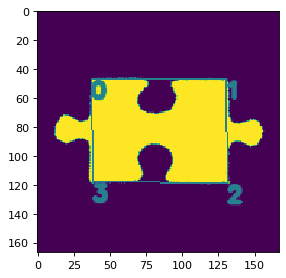

ROTATE IMAGE B 0, 2
====
(113, 117, 3)
(81, 81)


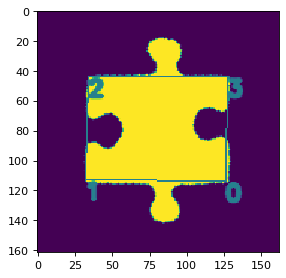

side A:1 B:0
A([107  86],[ 45 121]) B([ 39 112],[ 0 55])
side A:1 B:1
A([107  86],[ 45 121]) B([116  57],[ 39 112])
side A:1 B:2
A([107  86],[ 45 121]) B([75  0],[116  57])
side A:2 B:0
A([62  4],[107  86]) B([ 0 55],[75  0])
Rotate both candidate piece sides to the same horizontal reference
61.242879102697586
144.46232220802563
ROTATE IMAGE A 2, 0
====
(128, 108, 3)
(83, 83)


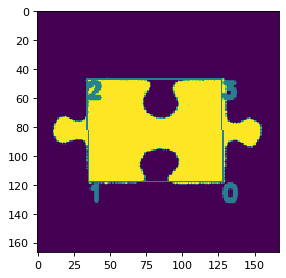

ROTATE IMAGE B 2, 0
====
(113, 117, 3)
(81, 81)


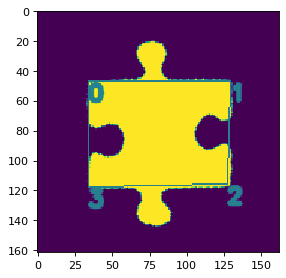

side A:2 B:1
A([62  4],[107  86]) B([ 39 112],[ 0 55])
side A:2 B:2
A([62  4],[107  86]) B([116  57],[ 39 112])
Rotate both candidate piece sides to the same horizontal reference
61.242879102697586
-36.25383773744479
ROTATE IMAGE A 2, 2
====
(128, 108, 3)
(83, 83)


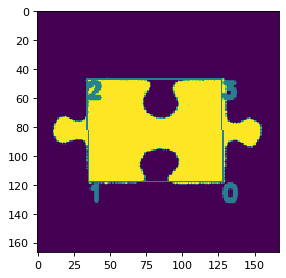

ROTATE IMAGE B 2, 2
====
(113, 117, 3)
(81, 81)


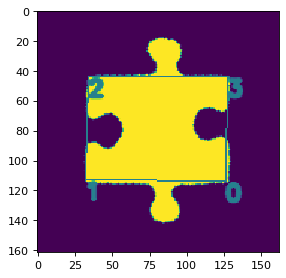

In [27]:
#Align sides and perform a XOR to find the best possible match
#Translate and rotate one piece a little to search for the best possible match too        
    
da = 0
db = 0
for dpiece1 in detected_pieces[:1]:
    da = da + 1
    for dpiece2 in detected_pieces[:2]:
        db = db + 1
        if da == db:
            continue
        pa = dpiece1.body_points[0]
        pb = dpiece2.body_points[0]
#         print(pa)
#         print(pb)

        shapeA = Shape(pa)
        shapeB = Shape(pb)

        for a in range(0,3):
            a1 = a%3
            a2 = a%3 + 1
            for b in range(0,3):
                b1 = b%3
                b2 = b%3 + 1
                print('side A:%s B:%s'%(a1,b1))
                print('A(%s,%s) B(%s,%s)' % (pa[0],pa[1],pb[0],pb[1]))
                #edge from A to B have internal body of the piece at its right and external part at left

                lengthA = shapeA.edge_length(a1)
                lengthB = shapeB.edge_length(b1)
                sameLength = calc.is_near(lengthA, lengthB, (lengthA+lengthB)*0.01)
            
                if sameLength:
                    print("Rotate both candidate piece sides to the same horizontal reference")
                    
                    angleA = shapeA.angle_point(a1)
                    if shapeA.point(a2)[0] < shapeA.point(a1)[0]:
                        angleA = angleA + 180
                        
                    angleB = shapeB.angle_point(b1)
                    if shapeB.point(b2)[0] < shapeA.point(b1)[0]:
                        angleB = angleB + 180
                        
                    print(angleA)
                    print(angleB)
                    
                    #translate pieces
#                     shapeA.rotate(angleA)
#                     calc.rotate_point((pax1,pax2), center, angleA)
                    
                    
                    #align two candidate pieces
                    
                    s = dpiece1.image.shape
                    h = s[0]
                    w = s[1]
                    center=(int(h/2), int(w/2))

                    
                    
                    print("ROTATE IMAGE A %d, %d" % (a,b))
                    imagera, maskra, body_shapea = dpiece1.rotate(center, angleA)
                
                    fig=plt.figure(figsize=(4, 4), dpi= 80, facecolor='w', edgecolor='k')
                    cv2.drawContours(maskra, np.array([[body_shapea.points]]), 0, (111,111,111))
                    for i in range(0, len(body_shapeb.points)):
                        bp = body_shapea.points[i]
                        cv2.putText(maskra, '%d'%i, (bp[0],bp[1]+13), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (111, 111, 111), 2, cv2.LINE_AA)
                    plt.imshow(maskra)
                    plt.show()


                    
                    
                    print("ROTATE IMAGE B %d, %d" % (a,b))
                    imagerb, maskrb, body_shapeb = dpiece2.rotate(center, angleB)
        
                    fig=plt.figure(figsize=(4, 4), dpi= 80, facecolor='w', edgecolor='k')
                    cv2.drawContours(maskrb, np.array([[body_shapeb.points]]), 0, (111,111,111))
                    for i in range(0, len(body_shapeb.points)):
                        bp = body_shapeb.points[i]
                        cv2.putText(maskrb, '%d'%i, (bp[0],bp[1]+13), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (111, 111, 111), 2, cv2.LINE_AA)
                    plt.imshow(maskrb)
                    plt.show()

                pb = np.roll(pb, 1, axis=0)
            pa = np.roll(pa, 1, axis=0)
